# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupling dynamic soil and hydraulic plant architecture models
In this Jupyter Notebook, we compine plant hydraulic architecture models with dynamic soil models. 
In the first part, we couple the plant hydraulic architecture with a dynamic soil grid at the macroscale. 
In the second part, we add individual perirhizal zone models around the single root segments. 


### Coupling plant hydraulic architecture to a macroscopic soil grid
Spatial coupling of the soil and the root hydraulic architecture is done in the *Mapped-Plant class* for general soil grids. *Mapped plant* is a specialisation of the *Plant class*, which keeps track of emerging new nodes and segments and their location inside the numerical soil grid. Therefore, the *MappedPlant class* needs a function that maps each point in space to a linear index (representing a grid cell used by the numeric solver). Temporal coupling as achieved  by solving each of the modules, plant and soil, sequentially, within each time step as described in Giraud et al. (2025).  

The following example simulates root water uptake by a growing root system from a drying soil. 

First, we import all the necessary libraries and set paths to the required directories of CPlantBox and DuMux-Rosi. 


In [1]:
import os, sys
sourcedir = os.getcwd()+"/../../../../"
sys.path.append(sourcedir); sys.path.append(sourcedir+"CPlantBox/"); sys.path.append(sourcedir+"CPlantBox/src/")
sys.path.append(sourcedir+"dumux-rosi/python/modules/");
sys.path.append(sourcedir+"dumux-rosi/build-cmake/cpp/python_binding/"); 

from rosi_richards import RichardsSPnum  # C++ part (Dumux binding)
from rosi_richards import RichardsSP
from richards import RichardsWrapper  # Python part  
from rosi_richards_cyl import RichardsCylFoam  # C++ part (Dumux binding), macroscopic soil model
from richards_flat import RichardsFlatWrapper  # Python part of cylindrcial

import plantbox as pb 
from functional.PlantHydraulicParameters import PlantHydraulicParameters  
from functional.PlantHydraulicModel import HydraulicModel_Doussan
from rosi_richards import RichardsSP  # C++ part (Dumux binding)

import numpy as np
import matplotlib.pyplot as plt
import visualisation.vtk_plot as vp # for quick vizualisations

import matplotlib.pyplot as plt  
import numpy as np 
import timeit

Next, we set all the necessary parameters for both the soil and the plant models, as well as numerical parameters, and initialise the models. Furthermore, we define points at which the results for the dynamic variables will be stored, in this case the soil cell in which the root collar is located.

In [2]:
def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


""" Parameters """
min_b = [-4., -4., -25.]
max_b = [4., 4., 0.]
cell_number = [8, 8, 25]  # [16, 16, 30]  # [32, 32, 60]
periodic = False

path = "../../../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified" 
loam = [0.08, 0.43, 0.04, 1.6, 50]
initial = -659.8 + 12.5  # -659.8

trans = 6.4  # cm3 /day (sinusoidal)
wilting_point = -15000  # cm

sim_time = 7  # [day] 
rs_age = 10  # root system initial age
age_dependent = False  # conductivities
dt = 360. / (24 * 3600)  # [days] Time step must be very small


""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "1000")
s.initializeProblem()
s.setCriticalPressure(wilting_point)

""" Initialize xylem model """
plant = pb.MappedPlant()
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
if not periodic:
    sdf = pb.SDF_PlantBox(0.95 * (max_b[0] - min_b[0]), 0.95 * (max_b[1] - min_b[1]), max_b[2] - min_b[2])
else:
    sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2])
plant.setGeometry(sdf)

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.read_parameters("../../../modelparameter/functional/plant_hydraulics/couvreur2012")
hm = HydraulicModel_Doussan(plant, params)  
# hm = HydraulicModel_Meunier(plant, params)
hm.wilting_point = wilting_point

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([x, y, z])
plant.setSoilGrid(picker)  # maps segments
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test()  # sanity checks

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 3199 nodes for 1600 grid entities in 0.000737117 seconds.
Computed bounding box tree with 3199 nodes for 1600 grid entities in 0.000601905 seconds.
MappedPlant::initializeLB 
PlantHydraulicModel.test():
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 10 days
nodes moved 0
new nodes added 2428
segments added 2428
Number of segments 2429, including 2428 new 
2430 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [-1.89827483e-03 -9.79223222e-03 -3.49990050e+00]
Node 3 [-3.74821672e-03 -2.20694487e-02 -3.99974632e+00]
Node 4 [-3.30632423e-03 -1.66025249e-02 -4.37634639e+00]
2429 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments 

In the main simulation loop, we sequentially perform (a) plant growth, (b) compute xylem pressure potential and (c) calculate the fluxes from soil grid cells into the plant roots as well as the soil matric potentials. The resulting actual transpiration at each time step is stored. Two figurs are produced, one that shows the soil matric potentials in the 3D soil domain as well as the root architecture and xylem pressure potentials, and a 2D plot that shows the actual, potential and cumulative transpiration with respect to time.  

In [3]:
""" Numerical solution """
start_time = timeit.default_timer()
x_, y_ = [], []
N = round(sim_time / dt)
t = 0.

for i in range(0, N):

    plant.simulate(dt)
    hs = s.getSolutionHead()
    hx = hm.solve(rs_age+t, -trans*sinusoidal(t), hs, cells=True)
    
    water = s.getWaterVolume()
    fluxes = hm.soil_fluxes(rs_age+t,hx,hs)
    s.setSource(fluxes)
    s.solve(dt)
    soil_water = (s.getWaterVolume() - water) / dt
    
    x_.append(t)
    y_.append(float(hm.get_transpiration(rs_age + t, hx, hs, cells=True)))  # exact root collar flux
    
    if i % 10 == 0:
        n = round(float(i) / float(N) * 100.)
        print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], [{:g}, {:g}] cm soil [{:g}, {:g}] cm root at {:g} days {:g}"
                .format(np.min(hs), np.max(hs), np.min(hx), np.max(hx), s.simTime, hx[0]))    

    t += dt

print ("Coupled problem solved in ", timeit.default_timer() - start_time, " s")

 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
[                                                                                                    ], [-659.3, -635.3] cm soil [-659.838, -641.108] cm root at 0.00416667 days -659.838
[*                                                                                                   ], [-659.698, -635.3] cm soil [-681.846, -643.842] cm root at 0.0458333 days -681.846
[*                                                                                                   ], [-670.183, -635.3] cm soil [-747.313, -650.057] cm root at 0.0875 days -747.313
[**                                                                                                  ], [-700.026, -635.3] cm soil [-852.974, -659.373] cm root at 0.129167 days -852.974
[**     

[**************************                                                                          ], [-2403.54, -635.308] cm soil [-2322.29, -849.25] cm root at 1.79583 days -2300.11
[**************************                                                                          ], [-2310.35, -635.309] cm soil [-2204.06, -834.757] cm root at 1.8375 days -2124.06
[***************************                                                                         ], [-2202.22, -635.311] cm soil [-2080.45, -820.113] cm root at 1.87917 days -1955.57
[***************************                                                                         ], [-2113.45, -635.313] cm soil [-1968.37, -807.131] cm root at 1.92083 days -1807.82
[****************************                                                                        ], [-2031.39, -635.316] cm soil [-1877.12, -796.036] cm root at 1.9625 days -1692
[*****************************                                         

[****************************************************                                                ], [-14971, -636.541] cm soil [-106501, -1086.95] cm root at 3.67083 days -4092.56
[*****************************************************                                               ], [-8854, -636.634] cm soil [-7147.37, -1091.99] cm root at 3.7125 days -4008.23
[******************************************************                                              ], [-5213.37, -636.733] cm soil [-4631.59, -1086.86] cm root at 3.75417 days -3837.53
[******************************************************                                              ], [-4195.06, -636.837] cm soil [-3886.51, -1078.36] cm root at 3.79583 days -3651.23
[*******************************************************                                             ], [-3799.5, -636.949] cm soil [-3583.78, -1060.01] cm root at 3.8375 days -3452.53
[*******************************************************                  

[*******************************************************************************                     ], [-4908.94, -652.627] cm soil [-4949.59, -1370.04] cm root at 5.54583 days -4949.59
[********************************************************************************                    ], [-5034.15, -653.482] cm soil [-5068.38, -1403.83] cm root at 5.5875 days -5068.38
[********************************************************************************                    ], [-5105.6, -654.373] cm soil [-5131.62, -1434.78] cm root at 5.62917 days -5131.62
[*********************************************************************************                   ], [-5116.38, -655.301] cm soil [-5133.57, -1460.41] cm root at 5.67083 days -5133.57
[**********************************************************************************                  ], [-5076.86, -656.266] cm soil [-5075.62, -1482.23] cm root at 5.7125 days -5075.62
[*******************************************************************

2025-09-04 17:10:11.911 ( 174.413s) [    75C0B0C9E600]       vtkXMLWriter.cxx:636    ERR| vtkXMLPolyDataWriter (0x22108c50): Error opening output file "results/Zeamays_synMRI_modified.vtp"
2025-09-04 17:10:11.911 ( 174.413s) [    75C0B0C9E600]       vtkXMLWriter.cxx:638    ERR| vtkXMLPolyDataWriter (0x22108c50): Error code "No such file or directory"
2025-09-04 17:10:11.911 ( 174.413s) [    75C0B0C9E600]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x24b18430): Algorithm vtkXMLPolyDataWriter (0x22108c50) returned failure for request: vtkInformation (0x24a2ed90)
  Debug: Off
  Modified Time: 162963
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-09-04 17:10:11.912 ( 174.414s) [    75C0B0C9E600]       vtkXMLWriter.cxx:636    ERR| vtkXMLImageDataWriter (0x24b69590): Error opening output file "results/Zeamays_synMRI_modified.vtu"
2025-09-04 17:10:11.912 ( 174.414s) [  

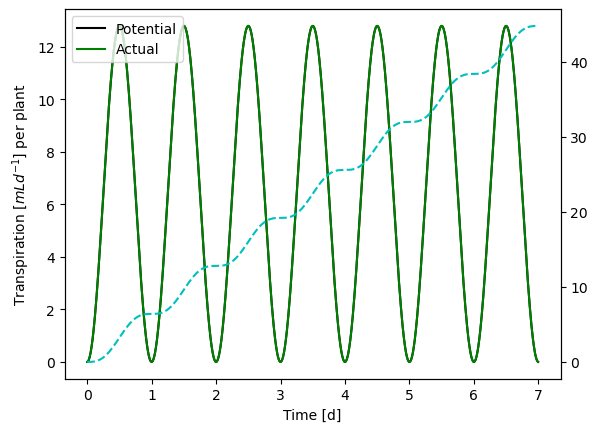

In [4]:
""" VTK visualisation """
vp.plot_roots_and_soil(hm.ms.mappedSegments(), "matric potential", hx, s, True, np.array(min_b), np.array(max_b), cell_number, name)

""" transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration (neumann)
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiration (neumann)
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
np.savetxt(name, np.vstack((x_, -np.array(y_))), delimiter = ';')
plt.show()